In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%203%20Lesson%202%20-%20RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
try:
    %tensorflow_version 2.x
except Exception:
    pass

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.0


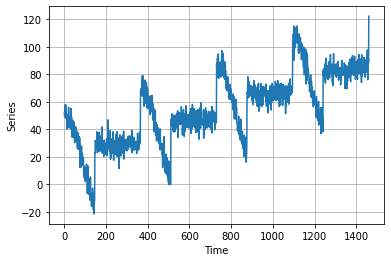

In [4]:
def plot_series(time, series, format = '-', start = 0, end = None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Series")
    plt.grid(True)

def trend(time, slope = 0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1 / np.exp(3 * season_time))

def seaonality(time, period, amplitude = 1, phase = 0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level =1, seed =None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype = 'float32')
baseline = 10
series = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

series = baseline + trend(time, slope) + seaonality(time, period=365, amplitude = amplitude)

series += noise(time, noise_level, seed = 42)
plot_series(time, series)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = time[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000


In [13]:
def windowed_dataset(series,  window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1 , shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1 ))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window:(window[:-1], window[-1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset


In [17]:
 tf.keras.backend.clear_session()
 tf.random.set_seed(51)
 np.random.seed(51)

 train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

 model = tf.keras.Sequential([
     tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [None]),
     tf.keras.layers.SimpleRNN(40, return_sequences= True), 
     tf.keras.layers.SimpleRNN(40),
     tf.keras.layers.Dense(1),
     tf.keras.layers.Lambda(lambda x: x * 100.0)
 ])

 lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch / 20))
 optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum=0.9)
 model.compile(loss = tf.keras.losses.Huber(), 
                optimizer = optimizer, 
                metrics = ['mae'])
 history = model.fit(train_set, epochs = 100, callbacks = [lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 19ms/step - loss: 194.1703 - mae: 194.6703
Epoch 2/100
31/31 [==============================] - 1s 18ms/step - loss: 188.7934 - mae: 189.2934
Epoch 3/100
31/31 [==============================] - 1s 19ms/step - loss: 182.0599 - mae: 182.5599
Epoch 4/100
31/31 [==============================] - 1s 19ms/step - loss: 174.1143 - mae: 174.6143
Epoch 5/100
31/31 [==============================] - 1s 19ms/step - loss: 164.5990 - mae: 165.0990
Epoch 6/100
31/31 [==============================] - 1s 19ms/step - loss: 152.8414 - mae: 153.3414
Epoch 7/100
31/31 [==============================] - 1s 19ms/step - loss: 137.4901 - mae: 137.9901
Epoch 8/100
31/31 [==============================] - 1s 19ms/step - loss: 116.4440 - mae: 116.9440
Epoch 9/100
31/31 [==============================] - 1s 19ms/step - loss: 87.3889 - mae: 87.8889
Epoch 10/100
31/31 [==============================] - 1s 19ms/step - loss: 49.9130 - mae: 50.4122
Epoch 11/100


(1e-08, 0.0001, 0.0, 30.0)

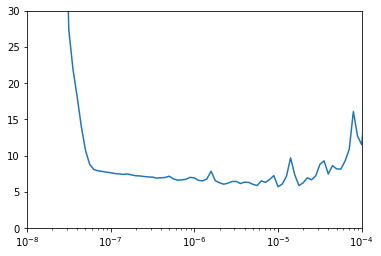

In [18]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8 , 1e-4, 0, 30])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

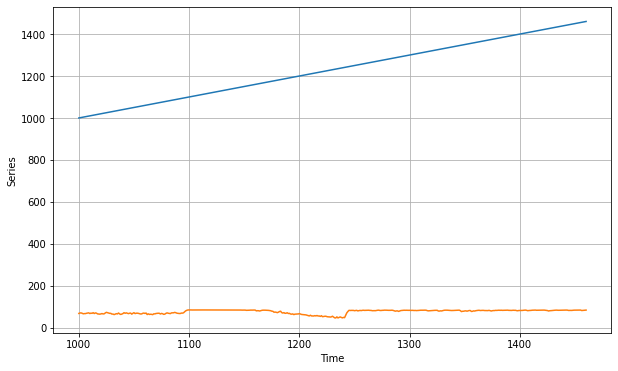

In [20]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()